### Importing libraries

In [1]:
import os
import sys
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType
from pyspark.sql.functions import coalesce, col, lit, when, date_format, hour, to_date, unix_timestamp, expr, mean
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

### Loading data

In [3]:
spark = SparkSession.builder.appName("Taxi").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/24 11:44:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
path = "/Users/afnan/Desktop/python/Data_science_Notes/Uber_data"

In [6]:
combined_df = spark.read.parquet('sample.parquet')

In [7]:
print(f"shape: ({combined_df.count()}, {len(combined_df.columns)})")

shape: (17459672, 25)


# 1. Data cleaning

In [8]:
column_types = combined_df.dtypes
column_types

[('hvfhs_license_num', 'string'),
 ('dispatching_base_num', 'string'),
 ('originating_base_num', 'string'),
 ('request_datetime', 'timestamp_ntz'),
 ('on_scene_datetime', 'timestamp_ntz'),
 ('pickup_datetime', 'timestamp_ntz'),
 ('dropoff_datetime', 'timestamp_ntz'),
 ('PULocationID', 'bigint'),
 ('DOLocationID', 'bigint'),
 ('trip_miles', 'double'),
 ('trip_time', 'bigint'),
 ('base_passenger_fare', 'double'),
 ('tolls', 'double'),
 ('bcf', 'double'),
 ('sales_tax', 'double'),
 ('congestion_surcharge', 'double'),
 ('airport_fee', 'double'),
 ('tips', 'double'),
 ('driver_pay', 'double'),
 ('shared_request_flag', 'string'),
 ('shared_match_flag', 'string'),
 ('access_a_ride_flag', 'string'),
 ('wav_request_flag', 'string'),
 ('wav_match_flag', 'string'),
 ('__index_level_0__', 'bigint')]

## 1.1 Categorical data cleaning

In [9]:
string_col = [col_name for col_name, col_type in column_types if col_type == "string"]
string_col

['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

In [10]:
# checking null values
for column in string_col:
    null_count = combined_df.filter(combined_df[column].isNull()).count()
    if null_count>0:
        print(f"{col}: ", null_count)

<function col at 0x115679360>:  4841601


In [11]:
# value counts of each categorical variable
for column in string_col:
    print(f"{column}: ", combined_df.select(column).distinct().count())

hvfhs_license_num:  3


dispatching_base_num:  34


originating_base_num:  41


shared_request_flag:  2
shared_match_flag:  2
access_a_ride_flag:  2
wav_request_flag:  2
wav_match_flag:  2


**hvfhs_license_num** - Indicate whether the taxi was of Uber, Lyft or Via

    - HV0003: Uber
    - HV0004: Via
    - HV0005: Lyft
**dispatching_base_num / originating_base_num** - License plate number of vehicle

All the other are boolean columns

In [12]:
# Encoding all the binary columns

In [13]:
binary_col = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 
              'wav_request_flag', 'wav_match_flag']

In [14]:
for bincol in binary_col:
    string_indexer = StringIndexer(inputCol=bincol, outputCol="index")
    model = string_indexer.fit(combined_df)
    combined_df = model.transform(combined_df)
    combined_df = combined_df.drop(bincol).withColumnRenamed("index", bincol)
    combined_df = combined_df.withColumn(bincol, col(bincol).cast("int"))
    

In [15]:
combined_df.select(binary_col).dtypes

[('shared_request_flag', 'int'),
 ('shared_match_flag', 'int'),
 ('access_a_ride_flag', 'int'),
 ('wav_request_flag', 'int'),
 ('wav_match_flag', 'int')]

In [16]:
# Renaming the values in hvfhs_license_num

In [17]:
combined_df = combined_df.withColumnRenamed("hvfhs_license_num","taxi_company")

In [18]:
combined_df = combined_df.na.replace(['HV0003', 'HV0004', 'HV0005'], ['Uber', 'Via', 'Lyft'], 'taxi_company')

In [19]:
combined_df.groupBy('taxi_company').count().show()

+------------+--------+
|taxi_company|   count|
+------------+--------+
|        Lyft| 4756545|
|         Via|   88923|
|        Uber|12614204|
+------------+--------+



**'PULocationID'** & **'DOLocationID'** are also categorical values

In [20]:
print(combined_df.select("PULocationID").distinct().count())
print(combined_df.select("DOLocationID").distinct().count())

263
263


In [21]:
taxi_zone_lookup = pd.read_csv(f'{path}/dataset/taxi_zone_lookup.csv')
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [22]:
taxi_zone_lookup.shape

(265, 4)

In [23]:
taxi_zone_lookup['Zone'].value_counts()[:3]

Zone
Governor's Island/Ellis Island/Liberty Island    3
Corona                                           2
Newark Airport                                   1
Name: count, dtype: int64

Zone Governor's Island/Ellis Island/Liberty Island and Corona have multiple values

In [24]:
taxi_zone_lookup[taxi_zone_lookup['Zone'].isin(["Governor's Island/Ellis Island/Liberty Island", "Corona"])]

,LocationID,Borough,Zone,service_zone
55,56,Queens,Corona,Boro Zone
56,57,Queens,Corona,Boro Zone
102,103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
103,104,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
104,105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone


In [25]:
print("56: ", combined_df.filter(combined_df.PULocationID==56).count())
print("57: ", combined_df.filter(combined_df.PULocationID==57).count())
print("103: ", combined_df.filter(combined_df.PULocationID==103).count())
print("104: ", combined_df.filter(combined_df.PULocationID==104).count())
print("105: ", combined_df.filter(combined_df.PULocationID==105).count())

56:  54291
57:  4012
103:  0
104:  0
105:  2


In [26]:
print("56: ", combined_df.filter(combined_df.DOLocationID==56).count())
print("57: ", combined_df.filter(combined_df.DOLocationID==57).count())
print("103: ", combined_df.filter(combined_df.DOLocationID==103).count())
print("104: ", combined_df.filter(combined_df.DOLocationID==104).count())
print("105: ", combined_df.filter(combined_df.DOLocationID==105).count())

56:  47590
57:  3689
103:  0
104:  1
105:  11


In [27]:
PUlocations = combined_df.select("PULocationID").distinct().collect()

In [28]:
PUlocations = [l[0] for l in PUlocations]

In [29]:
set(taxi_zone_lookup['LocationID'])^set(PUlocations)

{103, 104}

In [30]:
DOlocations = combined_df.select("DOLocationID").distinct().collect()

In [31]:
DOlocations = [l[0] for l in DOlocations]

In [32]:
set(taxi_zone_lookup['LocationID'])^set(DOlocations)

{103, 199}

In [33]:
combined_df.filter(combined_df.DOLocationID==199).count()

0

In [34]:
combined_df.filter(combined_df.PULocationID==199).count()

2

LocationID 103, 104, 105 and 199 are all islands that have no connecting route to them. Dropping the values as they are outliers.

In [35]:
combined_df = combined_df.filter(~(combined_df.PULocationID.isin([103, 104, 105, 199])))
combined_df = combined_df.filter(~(combined_df.DOLocationID.isin([103, 104, 105, 199])))

Combining LocationID 56 and 57.

In [36]:
combined_df = combined_df.na.replace(57, 56, ['PULocationID', 'DOLocationID'])

Checking value counts

In [37]:
pul = combined_df.groupBy("PULocationID").count().toPandas()
pul.sort_values('count').head()

,PULocationID,count
259,264,8
32,110,31
169,2,57
104,1,252
232,99,444


In [38]:
dol = combined_df.groupBy("DOLocationID").count().toPandas()
dol.sort_values('count').head()

,DOLocationID,count
259,264,8
32,110,36
169,2,63
232,99,432
160,8,747


In [39]:
taxi_zone_lookup[taxi_zone_lookup['LocationID'].isin([110, 2])]

,LocationID,Borough,Zone,service_zone
1,2,Queens,Jamaica Bay,Boro Zone
109,110,Staten Island,Great Kills Park,Boro Zone


In the map of New york *Jamaica Bay* is close to *Broad Channel* and *Great Kills Park* is close to *Great Kills*

In [40]:
taxi_zone_lookup[taxi_zone_lookup['Zone'].isin(["Broad Channel", 'Great Kills'])]

,LocationID,Borough,Zone,service_zone
29,30,Queens,Broad Channel,Boro Zone
108,109,Staten Island,Great Kills,Boro Zone


In [41]:
pul[pul['PULocationID'].isin([30, 109])]

,PULocationID,count
221,30,908
235,109,10709


In [42]:
dol[dol['DOLocationID'].isin([30, 109])]

,DOLocationID,count
221,30,934
235,109,9879


In [43]:
combined_df = combined_df.na.replace(2, 30, ['PULocationID', 'DOLocationID'])
combined_df = combined_df.na.replace(110, 109, ['PULocationID', 'DOLocationID'])

In [44]:
print(combined_df.select("PULocationID").distinct().count())
print(combined_df.select("DOLocationID").distinct().count())

258


258


## 1.2 Numeric data cleaning

In [45]:
bigint_col = [col_name for col_name, col_type in column_types if col_type == "bigint"]
double_col = [col_name for col_name, col_type in column_types if col_type == "double"]

In [46]:
bigint_col + double_col

['PULocationID',
 'DOLocationID',
 'trip_time',
 '__index_level_0__',
 'trip_miles',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay']

### 1.2.1 Getting rid of irrelevant columns
**(according to problem statement)**

In [47]:
drop_col = ['base_passenger_fare', 'bcf', 'sales_tax', 'congestion_surcharge', 'tips', 'driver_pay', '__index_level_0__']

In [48]:
combined_df = combined_df.drop(*drop_col)

In [49]:
bigint_col = [col_name for col_name, col_type in combined_df.dtypes if col_type == "bigint"]
double_col = [col_name for col_name, col_type in combined_df.dtypes if col_type == "double"]

In [50]:
bigint_col + double_col

['PULocationID',
 'DOLocationID',
 'trip_time',
 'trip_miles',
 'tolls',
 'airport_fee']

In [51]:
# checking null values
for column in bigint_col + double_col:
    null_count = combined_df.filter(combined_df[column].isNull()).count()
    if null_count>0:
        print(f"{column}: ", null_count)

airport_fee:  3649602


In [52]:
combined_df.describe(bigint_col).show()

+-------+------------------+------------------+------------------+
|summary|      PULocationID|      DOLocationID|         trip_time|
+-------+------------------+------------------+------------------+
|  count|          17459656|          17459656|          17459656|
|   mean|137.13401982261277|140.88124897764308|1101.3408439433172|
| stddev| 75.80578647896762| 78.26364739957337| 779.3774649538015|
|    min|                 1|                 1|                 0|
|    max|               265|               265|            130718|
+-------+------------------+------------------+------------------+



In [53]:
combined_df.describe(double_col).show()

+-------+-----------------+------------------+-------------------+
|summary|       trip_miles|             tolls|        airport_fee|
+-------+-----------------+------------------+-------------------+
|  count|         17459656|          17459656|           13810054|
|   mean|4.841753382884417|0.9451848570220589|0.14788505533722027|
| stddev|5.502533641301329|3.4914857282795317| 0.5932011278129279|
|    min|              0.0|               0.0|                0.0|
|    max|           527.11|            105.75|               10.0|
+-------+-----------------+------------------+-------------------+



In [54]:
combined_df.filter(combined_df.airport_fee==0).count()

12997495

In [55]:
# since there are 0 values we cannot replace all null values with 0.

### 1.2.2 Dealing with missing values

There is just one missing value in the numeric columns that is airport_fee. We have to use the **taxi_zone_lookup.csv** file to find the airport location and then using the **DOLocationID** column fill the missing values.

In [56]:
taxi_zone_lookup = pd.read_csv(f'{path}/dataset/taxi_zone_lookup.csv')

In [57]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


There are 3 airports in New york
- LaGuardia Airport (LGA)
- John F. Kennedy International Airport (JFK)
- Newark Liberty International Airport (EWR)

In [58]:
taxi_zone_lookup[taxi_zone_lookup['service_zone']=="EWR"]

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR


In [59]:
taxi_zone_lookup['service_zone'] = taxi_zone_lookup['service_zone'].str.replace('EWR','Airports')

In [60]:
taxi_zone_lookup[taxi_zone_lookup['service_zone']=="Airports"]

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,Airports
131,132,Queens,JFK Airport,Airports
137,138,Queens,LaGuardia Airport,Airports


In [61]:
airport_location = {}

In [62]:
for index, row in taxi_zone_lookup[taxi_zone_lookup['service_zone']=="Airports"].iterrows():
    airport_location[row['Zone']] = row['LocationID']

In [63]:
airport_location

{'Newark Airport': 1, 'JFK Airport': 132, 'LaGuardia Airport': 138}

In [64]:
combined_df.filter((combined_df.DOLocationID.isin(list(airport_location.values()))) & 
                   (combined_df['airport_fee'].isNull())).count()

67933

DOLocationID that are not part of airport zones are Zero

In [65]:
combined_df = combined_df.withColumn(
    "airport_fee",
    when(
        ~col("DOLocationID").isin(list(airport_location.values())),
        coalesce(col("airport_fee"), lit(0))
    ).otherwise(col("airport_fee"))
)

In [66]:
combined_df.filter(combined_df['airport_fee'].isNull()).count()

67933

There can be passengers that had drop off location at Airports but didn't pay airport fee. Since we don't have a way of finding out whether the passenger paid airport fee or not we would fill the null values with non-zero values.

In [67]:
combined_df.filter(combined_df.airport_fee>0).count()

812559

The information provided by TLC states that the airport fee for all airports is $2.50. From the above KDE plot we can clearly see that all the airport_fee is surrounded by the mean value with low std. therefore we replace all values with the 2.5

In [68]:
# Filling null values of each airport's fee with $2.5

for loc in airport_location:
    combined_df = combined_df.withColumn(
        "airport_fee",
        when(
            col("DOLocationID")==airport_location[loc],
            coalesce(col("airport_fee"), lit(2.5))
        ).otherwise(col("airport_fee"))
    )

In [69]:
combined_df.filter(combined_df.airport_fee.isNull()).count()

0

### 1.2.3 Handling outliers

**Handling cancelled trips**
-  Getting rid of 0 values in trip_miles and trip_time as the trip might have been cancelled for some reasons.

In [70]:
combined_df = combined_df.filter(combined_df.trip_miles>0)
combined_df = combined_df.filter(combined_df.trip_time>0)

In [71]:
combined_df.count()

17454322

Useful data

In [72]:
location_df = combined_df.groupBy('PULocationID', 'DOLocationID')\
            .agg(F.max("trip_time"),
                 F.expr('percentile(trip_time, array(0.50))')[0].alias('trip_time_%50'),
                 F.expr('percentile(trip_time, array(0.99))')[0].alias('trip_time_%99'),
                 F.count('*')).toPandas()

**trip_time**

In [73]:
combined_df.select('trip_time').summary('95%', '99%' ,'max').show()

+-------+---------+
|summary|trip_time|
+-------+---------+
|    95%|     2558|
|    99%|     3855|
|    max|   130718|
+-------+---------+



In [74]:
location_df['trip_time_%99'].max()

66508.32000000025

In [75]:
location_df['trip_time_%50'].quantile(.99)

4416.0

In [76]:
location_df[location_df['trip_time_%50']>4000]['count(1)'].sum()

3003

In [77]:
combined_df = combined_df.filter(combined_df.trip_time<4000)

In [78]:
combined_df.select('trip_time').summary('min', '1%', '5%').show()

+-------+---------+
|summary|trip_time|
+-------+---------+
|    min|        1|
|     1%|      196|
|     5%|      307|
+-------+---------+



In [79]:
location_df[location_df['trip_time_%50']<200]['count(1)'].sum()

5

In [80]:
combined_df = combined_df.filter(combined_df.trip_time>200)

**trip_miles**

In [81]:
location_df = combined_df.groupBy('PULocationID', 'DOLocationID')\
            .agg(F.max("trip_miles"),
                 F.expr('percentile(trip_miles, array(0.5))')[0].alias('trip_miles_%50'),
                 F.expr('percentile(trip_miles, array(0.99))')[0].alias('trip_miles_%99'),
                 F.count('*')).toPandas()

In [82]:
combined_df.select('trip_miles').summary('95%', '99%' ,'max').show()

+-------+----------+
|summary|trip_miles|
+-------+----------+
|    95%|     14.58|
|    99%|      22.3|
|    max|    94.599|
+-------+----------+



In [83]:
print(location_df['trip_miles_%99'].max())
print(location_df['trip_miles_%50'].max())
print(location_df['trip_miles_%50'].quantile(.99))

86.19385000000001
76.834
31.081524999999996


In [84]:
location_df[location_df['trip_miles_%50']>30]['count(1)'].sum()

2584

In [85]:
combined_df = combined_df.filter(combined_df.trip_miles<30)

In [86]:
combined_df.select('trip_miles').summary('min', '1%', '5%').show()

+-------+----------+
|summary|trip_miles|
+-------+----------+
|    min|     0.002|
|     1%|     0.574|
|     5%|      0.86|
+-------+----------+



In [87]:
combined_df = combined_df.filter(combined_df.trip_miles>0.5)

### 1.2.4 Univariate analysis

In [88]:
bigint_col+double_col

['PULocationID',
 'DOLocationID',
 'trip_time',
 'trip_miles',
 'tolls',
 'airport_fee']

**PULocationID** and **DULocationID** are categorical values, **airport_fee** is a constant value and **tolls** is a price column that is not related to our target column

In [89]:
seed = np.random.randint(0,100,3)

trip_time


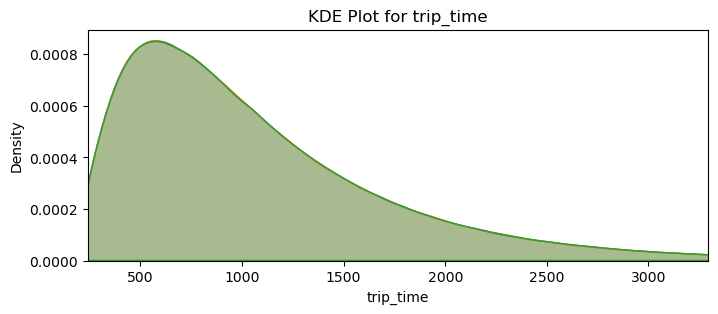

trip_miles


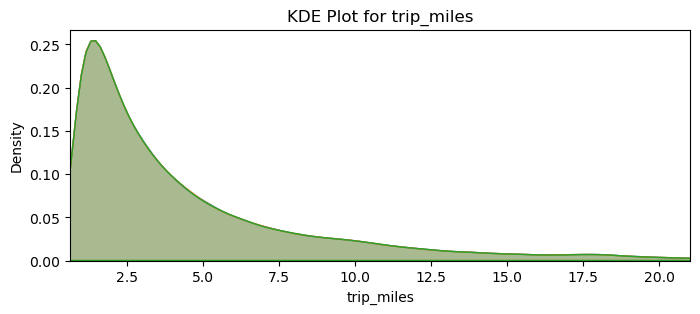

In [90]:
for column in ['trip_time', 'trip_miles']:
    plt.figure(figsize=(8, 3))

    for s in seed:
        sample_data = combined_df.select(column).sample(False, 0.1, seed=s).toPandas()

        max_value = np.percentile(sample_data[column], 99)
        min_value = np.percentile(sample_data[column], 1)

        sns.kdeplot(sample_data[column], fill=True)
        plt.title(f'KDE Plot for {column}')
        plt.xlim(min_value, max_value)

    # Show the plot
    print(column)
    plt.show()

## 1.3 Time series data cleaning

In [91]:
time_col = [col_name for col_name, col_type in column_types if col_type == "timestamp_ntz"]
time_col

['request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime']

In [92]:
# checking null values
for column in time_col:
    null_count = combined_df.filter(combined_df[column].isNull()).count()
    if null_count>0:
        print(f"{column}: ", null_count)

on_scene_datetime:  4712516


***

# 2. Feature Engineering

## 2.1 Numeric feature engineering

### 2.1.1 Trip time : seconds -> minutes

In [93]:
combined_df = combined_df.withColumn("trip_time", lit(combined_df.trip_time/60))

In [94]:
combined_df.describe('trip_time').show()

+-------+------------------+
|summary|         trip_time|
+-------+------------------+
|  count|          16973610|
|   mean| 17.92227409392155|
| stddev|11.014749968416682|
|    min|              3.35|
|    max|             66.65|
+-------+------------------+



### 2.1.2 Tolls boolean: Are there any tolls

In [95]:
combined_df.filter(combined_df.tolls>0).count()

2024058

In [96]:
combined_df = combined_df.withColumn("any_tolls", when(col("tolls") > 0, 1).otherwise(0))

In [97]:
combined_df.filter(combined_df.any_tolls==1).count()

2024058

### 2.1.3 Airport boolean: Is it an airport zone

In [98]:
combined_df.filter(combined_df.airport_fee>0).count()

822813

In [99]:
combined_df = combined_df.withColumn("airport_zone", when(col("airport_fee") > 0, 1).otherwise(0))

In [100]:
combined_df.filter(combined_df.airport_zone==1).count()

822813

### 2.1.4 Minutes per mile

In [101]:
combined_df = combined_df.withColumn("minutes_per_mile", combined_df.trip_time/combined_df.trip_miles)

In [102]:
combined_df.describe('minutes_per_mile').show()

+-------+-------------------+
|summary|   minutes_per_mile|
+-------+-------------------+
|  count|           16973610|
|   mean|  5.203728376971703|
| stddev| 2.4263388455561947|
|    min|0.38212537501973787|
|    max|              125.0|
+-------+-------------------+



In [103]:
combined_df.select('minutes_per_mile').summary('95%', '99%' ,'max').show()

+-------+------------------+
|summary|  minutes_per_mile|
+-------+------------------+
|    95%| 9.394506866416979|
|    99%|12.891156462585034|
|    max|             125.0|
+-------+------------------+



In [104]:
combined_df = combined_df.filter(combined_df.minutes_per_mile<13)

## 2.2 Time series feature engineering

### 2.2.1 Get date of trip

In [105]:
combined_df = combined_df.withColumn("pickup_date", to_date(col("pickup_datetime")))

### 2.2.2 Hour of the day

In [106]:
combined_df = combined_df.withColumn("hour_of_day", hour(col("pickup_datetime")))

In [107]:
combined_df.describe('hour_of_day').show()

+-------+------------------+
|summary|       hour_of_day|
+-------+------------------+
|  count|          16810291|
|   mean|13.489036447971067|
| stddev| 6.398171374638868|
|    min|                 0|
|    max|                23|
+-------+------------------+



### 2.2.3 Get day of the week 

In [108]:
combined_df = combined_df.withColumn("day_of_week", date_format(col("pickup_datetime"), "EEEE"))

In [109]:
combined_df.select('day_of_week').distinct().show()

+-----------+
|day_of_week|
+-----------+
|  Wednesday|
|    Tuesday|
|     Friday|
|   Thursday|
|   Saturday|
|     Monday|
|     Sunday|
+-----------+



### 2.2.4 Month of trip

In [110]:
combined_df = combined_df.withColumn('month', date_format('pickup_date', 'MMMM'))

In [111]:
combined_df.select('month').distinct().show()

+---------+
|    month|
+---------+
| February|
|  January|
|    March|
|    April|
|      May|
|     July|
|     June|
|   August|
|  October|
|September|
| November|
| December|
+---------+



### 2.2.5 Traffic by hour

In [112]:
traffic_df = combined_df.groupBy('pickup_date', 'hour_of_day').count().toPandas()
traffic = traffic_df[['count', 'hour_of_day']].groupby('hour_of_day', as_index=False).aggregate(['mean','median'])

In [113]:
traffic.columns = traffic.columns.droplevel(0)
traffic = traffic.reset_index()

<Axes: xlabel='hour_of_day'>

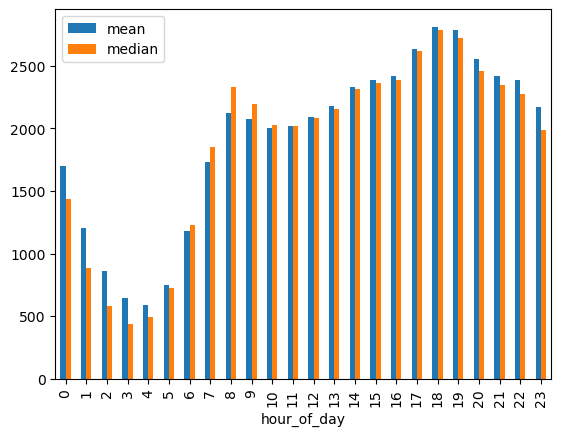

In [114]:
traffic.plot.bar(x='hour_of_day', y=['mean', 'median'])

Mean and Median are similar.

Since the sample size is 1/10th of the population, multiplying the traffic by 10 to get real values.

In [115]:
traffic_df = traffic_df.rename(columns={'count':'traffic'}).round({'traffic':-2})

In [116]:
traffic_df['traffic'] = traffic_df['traffic']*10

In [117]:
schema = StructType([
    StructField("pickup_date", DateType(), True),
    StructField("hour_of_day", IntegerType(), True),
    StructField("traffic", IntegerType(), True)
])

spark_df = spark.createDataFrame(traffic_df, schema=schema)

In [118]:
combined_df = combined_df.join(spark_df, on=['pickup_date', 'hour_of_day'])

## 2.3 Categorical feature engineering

### 2.3.1 Pickup and drop off Borough

In [119]:
borough = pd.read_csv(f'{path}/dataset/taxi_zone_lookup.csv')

In [120]:
borough.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [121]:
borough.Borough.unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

In [122]:
borough.Borough.isnull().sum()

0

In [123]:
borough[borough.Borough=='Unknown']

,LocationID,Borough,Zone,service_zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


In [124]:
schema = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("Borough", StringType(), True)
])

spark_df = spark.createDataFrame(borough[['LocationID', 'Borough']], schema=schema)

In [125]:
spark_df.head()

Row(LocationID=1, Borough='EWR')

In [126]:
combined_df = combined_df.join(spark_df, col("PULocationID") == col("LocationID")).drop('LocationID')\
                        .withColumnRenamed('Borough', 'PUBorough')
combined_df  = combined_df.join(spark_df, col("DOLocationID") == col("LocationID")).drop('LocationID')\
                        .withColumnRenamed('Borough', 'DOBorough')

### 2.3.2 Pickup and drop off service zone

In [127]:
borough.service_zone.isnull().sum()

2

In [128]:
borough.service_zone = borough.service_zone.fillna('Other')

In [129]:
borough[borough.service_zone=='Other']

,LocationID,Borough,Zone,service_zone
263,264,Unknown,NV,Other
264,265,Unknown,NaN,Other


In [130]:
borough.service_zone.value_counts()

service_zone
Boro Zone      205
Yellow Zone     55
Airports         2
Other            2
EWR              1
Name: count, dtype: int64

In [131]:
borough = borough.replace('EWR', 'Airports')

In [132]:
schema = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("service_zone", StringType(), True)
])

spark_df = spark.createDataFrame(borough[['LocationID', 'service_zone']], schema=schema)

In [133]:
combined_df = combined_df.join(spark_df, col("PULocationID") == col("LocationID")).drop('LocationID')\
                        .withColumnRenamed('service_zone', 'PUservice_zone')
combined_df  = combined_df.join(spark_df, col("DOLocationID") == col("LocationID")).drop('LocationID')\
                        .withColumnRenamed('service_zone', 'DOservice_zone')

In [134]:
combined_df.filter((combined_df.PUservice_zone=='Other') | (combined_df.DOservice_zone=="Other")).count()

533148

In [135]:
combined_df.filter((combined_df.PULocationID==265) | (combined_df.DOLocationID==265)).count()

533145

In [136]:
634835 - 634830

5

Dropping LocationID == 264

In [137]:
combined_df = combined_df.filter((combined_df.PULocationID!=264) & (combined_df.DOLocationID!=264))

LocationID 265 has a large no. of values but we don't know detail about the Zone or Borough. Therefore I am dropping the value to avoid overfitting. 

In [138]:
combined_df = combined_df.filter((combined_df.PULocationID!=265) & (combined_df.DOLocationID!=265))

In [139]:
combined_df.count()

16277143

### 2.3.3 Combine service zone and airport_zone

In [140]:
airports_df = combined_df.filter((combined_df.PUservice_zone!='Airports') &  
                   (combined_df.DOservice_zone!='Airports') & 
                   (combined_df.airport_zone==1))

In [141]:
airports_df.count()

48

In [142]:
combined_df = combined_df.drop("airport_zone")

### 2.3.3 Public holiday

In [143]:
holiday = pd.read_csv(f"{path}/dataset/public_holidays.csv", parse_dates=['Date'])

In [144]:
holiday.head(3)

,Date,Day,Holiday
0,2021-01-01,Friday,New Year's Day
1,2021-01-18,Monday,"Birthday of Martin Luther King, Jr."
2,2021-02-12,Friday,Lincoln's Birthday


In [145]:
holiday.shape

(12, 3)

In [146]:
schema = StructType([
    StructField("Date", DateType(), True), 
    StructField("Holiday", StringType(), True)
])

In [147]:
spark_holiday = spark.createDataFrame(holiday.drop(columns='Day'), schema = schema)

In [148]:
combined_df = combined_df.join(spark_holiday, col("pickup_date") == col("Date"), how="left_outer").drop('Date')

In [149]:
combined_df.filter(combined_df.Holiday.isNull()).count()

15807374

In [150]:
combined_df = combined_df.na.fill("NA", subset=['Holiday'])

In [151]:
len(combined_df.columns)

30

## 3 Combining weather data

In [152]:
weather_df = pd.read_csv(f"{path}/dataset/weather_processed.csv")
weather_df.head()

,timestamp,humidity,wind_direction,wind_speed,precipitation,pressure,visibility,skyc1,skyc2,skyc3,...,month,avg_skyl,RA,SN,DZ,TS,FG,FZ,CLR,BR
0,2021-01-01 00:51:00,57.47,NW,13.0,0,30.34,2,FEW,OVC,missing,...,1,9000.0,0,0,0,0,0,0,1,0
1,2021-01-01 01:51:00,54.77,N,9.0,0,30.35,2,FEW,SCT,missing,...,1,10000.0,0,0,0,0,0,0,1,0
2,2021-01-01 02:51:00,61.62,N,7.0,0,30.38,2,FEW,FEW,missing,...,1,20500.0,0,0,0,0,0,0,1,0
3,2021-01-01 03:51:00,63.98,N,10.0,0,30.41,2,FEW,FEW,missing,...,1,20500.0,0,0,0,0,0,0,1,0
4,2021-01-01 04:51:00,63.86,N,9.0,0,30.42,2,FEW,FEW,missing,...,1,21000.0,0,0,0,0,0,0,1,0


In [153]:
spark_weather = spark.createDataFrame(weather_df.drop(columns=['timestamp', 'month']))

In [154]:
spark_weather = spark_weather.withColumn("date", spark_weather.date.cast("timestamp"))

In [155]:
combined_df = combined_df.join(spark_weather, (col("pickup_date") == col("date")) & \
                 (col("hour_of_day") == col("hour"))).drop('hour', 'date')

***

# Target column

Our target column is **trip_time**

In [156]:
# Checking whether trip_time is (request - drop-off) or (pickup - drop-off) or (on_scene - drop-off)

In [157]:
trip_time_df = combined_df.select('request_datetime', 'pickup_datetime', 'on_scene_datetime', 'dropoff_datetime', 'trip_time')

In [158]:
trip_time_df = trip_time_df.withColumn("request_datetime", combined_df.request_datetime.cast("timestamp"))
trip_time_df = trip_time_df.withColumn("pickup_datetime", combined_df.pickup_datetime.cast("timestamp"))
trip_time_df = trip_time_df.withColumn("on_scene_datetime", combined_df.on_scene_datetime.cast("timestamp"))
trip_time_df = trip_time_df.withColumn("dropoff_datetime", combined_df.dropoff_datetime.cast("timestamp"))

In [159]:
trip_time_df

DataFrame[request_datetime: timestamp, pickup_datetime: timestamp, on_scene_datetime: timestamp, dropoff_datetime: timestamp, trip_time: double]

In [160]:
trip_time_df = trip_time_df.withColumn("request_diff", lit(expr("unix_timestamp(dropoff_datetime) - unix_timestamp(request_datetime)")/60))
trip_time_df = trip_time_df.withColumn("pickup_diff", lit(expr("unix_timestamp(dropoff_datetime) - unix_timestamp(pickup_datetime)")/60))
trip_time_df = trip_time_df.withColumn("on_scene_diff", lit(expr("unix_timestamp(dropoff_datetime) - unix_timestamp(on_scene_datetime)")/60))

In [161]:
trip_time_df

DataFrame[request_datetime: timestamp, pickup_datetime: timestamp, on_scene_datetime: timestamp, dropoff_datetime: timestamp, trip_time: double, request_diff: double, pickup_diff: double, on_scene_diff: double]

In [162]:
trip_time_df = trip_time_df.withColumn("rq_diff", trip_time_df.request_diff - trip_time_df.trip_time)
trip_time_df = trip_time_df.withColumn("pu_diff", trip_time_df.pickup_diff - trip_time_df.trip_time)
trip_time_df = trip_time_df.withColumn("on_diff", trip_time_df.on_scene_diff - trip_time_df.trip_time)

In [163]:
trip_time_df.select("rq_diff", "pu_diff", "on_diff").summary().show()

24/01/24 11:52:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------------------+------------------+
|summary|           rq_diff|             pu_diff|           on_diff|
+-------+------------------+--------------------+------------------+
|  count|          16277143|            16277143|          11772042|
|   mean|  5.49429351330274|-0.06460203120410546|0.9705877479314954|
| stddev| 3.648380529100645|  0.6568986550974533|1.0322359477454524|
|    min|-66.31666666666666|              -70.95|            -60.65|
|    25%|  3.31666666666667|                 0.0|0.2999999999999998|
|    50%| 4.816666666666666|                 0.0|0.7333333333333343|
|    75%| 6.933333333333334|                 0.0| 1.666666666666667|
|    max| 352.1333333333333|   60.00000000000001|             154.0|
+-------+------------------+--------------------+------------------+



From the above table we can clearly see that pickup difference is the smallest which indicates that trip_time starts at the pickup_datetime

## Dropping irrelevant columns

In [164]:
combined_df.columns

['pickup_date',
 'hour_of_day',
 'taxi_company',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'tolls',
 'airport_fee',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'any_tolls',
 'minutes_per_mile',
 'day_of_week',
 'month',
 'traffic',
 'PUBorough',
 'DOBorough',
 'PUservice_zone',
 'DOservice_zone',
 'Holiday',
 'humidity',
 'wind_direction',
 'wind_speed',
 'precipitation',
 'pressure',
 'visibility',
 'skyc1',
 'skyc2',
 'skyc3',
 'feel',
 'snowdepth',
 'avg_skyl',
 'RA',
 'SN',
 'DZ',
 'TS',
 'FG',
 'FZ',
 'CLR',
 'BR']

- **originating_base_num** is the base number of the base that received the original trip request and not the one that carried the trip. i.e is *dispatching_base_num*

- **request_datetime** & **on_scene_datetime** - Aim is to predict the ETA for the trip and not including waiting time.

- **pickup_datetime** & **dropoff_datetime** - Info extracted in form of day, hour, month, etc. 

- **tolls** - replaced with any_tolls

- **airport_fee** - replaced with service_zone

In [165]:
drop_columns = ['originating_base_num', 'request_datetime', 'on_scene_datetime', 'pickup_datetime', 
                'dropoff_datetime', 'tolls', 'airport_fee']

In [166]:
combined_df = combined_df.drop(*drop_columns)

In [167]:
print(f"shape: ({combined_df.count()}, {len(combined_df.columns)})")

shape: (16277143, 43)


In [169]:
# combined_df.write.mode('overwrite').parquet("preprocessed")

24/01/24 11:55:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
